In [228]:
using GeometryBasics
using CairoMakie
using Plots

In [229]:
# The linesource is a basic test model for the simulation, if the value is false a plane is generated on the SF/TF interface.
# It can be used to test the PML and simulate the circular propagation of the wave.
# The linesource by it selfe acts as a PEC.
line_source = true;
# PEC objects as scatter-objects.
# If both objects should be present in one simulation theier position should be modified in the following.
cyl_present = false;
cube_present = false;

In [230]:
# Physical constants
c = 2.997925e8;           # [m/s] Speed of light in vacuum
eps_0 = 8.854187817e-12;  # [F/m] ϵ_0
mu_0 = 4*pi*1e-7;         # [H/m] μ_0
eta_0 = sqrt(mu_0/eps_0);

In [231]:
# Simulation area
# Size in x and y direction can be changed.
# For increased x diraction the simulation time might be to small
sizeX = 1      # [m] size of simulation region
sizeY = 2      # [m] size of simulation region
# Refinement is sufficient with 200 cells/m.
refinement = 200    # [cells/m] 
# Number of time steps determines the simulation time. 
# If the simulation area is increased in x direction this value has to be modified.
M = 350                   # Number of time steps
# SF/TF can be moved to any value from 0 to N_x
L = Int(round(N_x/2))    # scat/tot field boundary 

N_x = Int(refinement*sizeX)      # number of cells in x-direction
N_y = Int(refinement*sizeY)      # number of cells in y-direction
delta_s = sizeX/N_x       # [m] spatial step   
R = 1                                 # fraction of Courant limit. Must be <= 1
delta_t = R * delta_s/(c * sqrt(2))   # [s] Time step size
sigma = 5.0e-11      # Controls spectral content of Gaussian derivative pulse equals 1/omega_max

# Plane wave starts with an offset. Line source starts directly.
m_offset = 4*sigma;  # Controls switch-on time
Peak = 1;            # Peak amplitude of E field

# PEC cylinder position at x=0.75m y=0.5m.
radius = 0.03 # [m] radius of cylinder
N_centre_x = Int(round(0.75*N_x));
N_centre_y = Int(round(0.6*N_y));
# PEC Cube position at 
sides = 0.1  # [m] side length of cube
N_centre_x_cub = Int(round(0.75*N_x));
N_centre_y_cub = Int(round(0.3*N_y));

# Set up storage for time histories in singele point.
H_z_point1 = zeros(1,M)
E_y_point1 = zeros(1,M)
# Position of point can be modified, but has to be in simulation region.
point1_x = Int(round(0.6*N_x))
point1_y = Int(round(N_y/2))

200

In [232]:
# Set up material grid (free space to start)
sigma_x = zeros(N_x,N_y);
sigma_y = zeros(N_x,N_y);
sigma_ast_x = zeros(N_x,N_y);
sigma_ast_y = zeros(N_x,N_y);

In [233]:
# Set up PML
poly_m = 3
sigma_max = 0.8*(poly_m+1)/(eta_0*delta_s)
d_cell = 10
# For y-absorption.
for jj = 1:d_cell
    dist = d_cell-(jj-1)
    sigma_y[:,jj] .= sigma_max*(dist/d_cell)^poly_m
    sigma_y[:,N_y-jj+1] = sigma_y[:,jj]
end

for jj = 1:d_cell
    dist = d_cell-(jj-1)-0.5; # Hz field components located delta/2 away.
    sigma_ast_y[:,jj] .= eta_0^2*sigma_max*(dist/d_cell)^poly_m;
    sigma_ast_y[:,N_y-jj] = sigma_ast_y[:,jj];
end

# For x-absorption. Corner regions are automatically overlapped.
for ii = 1:d_cell
    dist = d_cell-(ii-1);
    sigma_x[ii,:] .= sigma_max*(dist/d_cell)^poly_m;
    sigma_x[N_x-ii+1,:] = sigma_x[ii,:];
end

for ii = 1:d_cell
    dist = d_cell-(ii-1)-0.5; # Hz field components located delta/2 away.
    sigma_ast_x[ii,:] .= eta_0^2*sigma_max*(dist/d_cell)^poly_m;
    sigma_ast_x[N_x-ii,:] = sigma_ast_x[ii,:];
end

In [234]:
C_aEx = (1 .- sigma_y * delta_t / (2*eps_0)) ./ (1 .+sigma_y*delta_t/(2*eps_0)); 
C_bEx = delta_t / (eps_0*delta_s) ./ (1 .+ sigma_y * delta_t / (2*eps_0));
C_aEy = (1 .-sigma_x*delta_t/(2*eps_0))./(1 .+sigma_x*delta_t/(2*eps_0)); 
C_bEy = delta_t/(eps_0*delta_s)./(1 .+sigma_x*delta_t/(2*eps_0));
D_aHzx = (1 .-sigma_ast_x*delta_t/(2*mu_0))./(1 .+sigma_ast_x*delta_t/(2*mu_0)); 
D_bHzx = delta_t/(mu_0*delta_s)./(1 .+sigma_ast_x*delta_t/(2*mu_0));
D_aHzy = (1 .-sigma_ast_y*delta_t/(2*mu_0))./(1 .+sigma_ast_y*delta_t/(2*mu_0)); 
D_bHzy = delta_t/(mu_0*delta_s)./(1 .+sigma_ast_y*delta_t/(2*mu_0));

# Modifiy simulation region if cylinder is present.
if cyl_present 
    for ii = 1:N_x
        for jj = 1:N_y
            if (sqrt(((ii-1/2-(N_centre_x-1))*delta_s)^2 + ((jj-1-(N_centre_y-1))*delta_s)^2 ) <= radius) 
                C_bEx[ii,jj] = 0;
            end
            if (sqrt(((ii-1-(N_centre_x-1))*delta_s)^2 + ((jj-1/2-(N_centre_y-1))*delta_s)^2 ) <= radius) 
                C_bEy[ii,jj] = 0;
            end
        end
    end
end 

# Modifiy simulation region if cube is present.
if cube_present 
    for x = N_centre_x_cub-Int(sides/(delta_s*2)):N_centre_x_cub+Int(sides/(delta_s*2))
        for y = N_centre_y_cub-Int(sides/(delta_s*2)):N_centre_y_cub+Int(sides/(delta_s*2)) 
            if y < N_centre_y_cub+Int(sides/(delta_s*2))
                C_bEy[x,y] = 0;
            end
            if x < N_centre_x_cub+Int(sides/(delta_s*2))
                C_bEx[x,y] = 0;
            end
        end
    end
end 

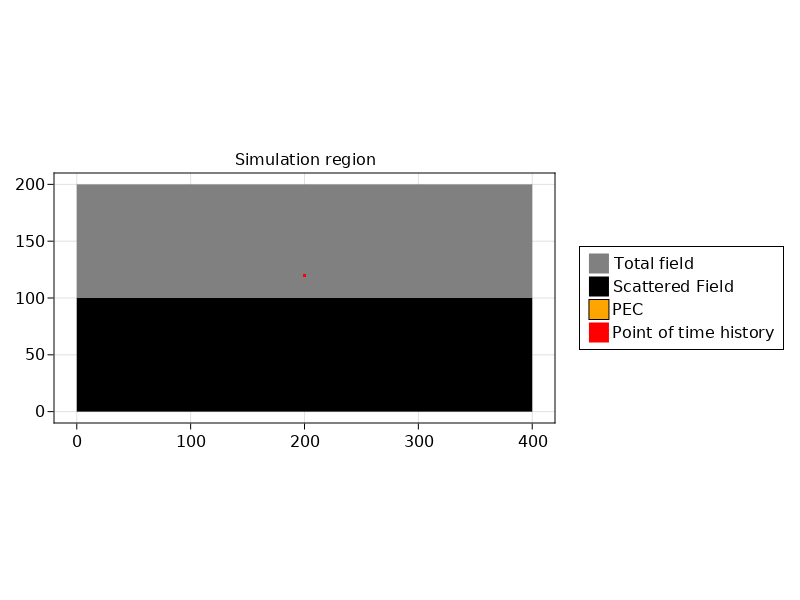

In [235]:
# Visualisation of selected simulation region. 
# This cell is just for visualisation and will not affect the simulation.

sim_region = Figure()
Axis(sim_region[1, 1], aspect = DataAspect(), title="Simulation region")
up_L=poly!(Rect(0,L,N_y,L), color = :grey)
un_L=poly!(Rect(0,0,N_y,L), color = :black)

if cyl_present
    Cyl =poly!(Circle(Point2f0(
        N_centre_y, N_centre_x),
        radius/delta_s),
        color = :orange,
        strokecolor = :black,
        strokewidth = 1
    )
end

if cube_present
    poly!(Rect(N_centre_y_cub,N_centre_x_cub,sides/delta_s,sides/delta_s), 
        color=:orange,
        strokecolor = :black,
        strokewidth = 1
    )
end

meas=poly!(Circle(Point2f0(point1_y, point1_x), 1), color = :red)
Legend(
    sim_region[1, 2],
    [up_L, un_L, Cyl, meas],
    ["Total field", "Scattered Field", "PEC", "Point of time history"]
)
sim_region

In [236]:
# Pulse of incident wave.
# Normalized gaussian derivative pulse.
function gaussder_norm(t,m,sigma)
    y = -exp(0.5)*(t-m)/sigma*exp(-(t-m)^2/(2*sigma^2))
    return y
end

gaussder_norm (generic function with 1 method)

In [237]:
# First time step - Initialize values for H_z, E_x and E_y
H_zx_nmin1 = zeros(N_x,N_y); 
H_zy_nmin1 = zeros(N_x,N_y); 
E_x_nmin1 = zeros(N_x,N_y); 
E_y_nmin1 = zeros(N_x,N_y); 

# Pre-allocation
H_zx_n = zeros(N_x,N_y); 
H_zy_n = zeros(N_x,N_y); 
H_z_n = zeros(N_x,N_y); 
E_x_n = zeros(N_x,N_y); 
E_y_n = zeros(N_x,N_y);
E_y_ninc = zeros(N_y);
H_z_ninc = zeros(N_y);

movieH = []

# Time loop
for m = 2:M   
    # Update H fields: 
    H_zx_n[1:N_x-1,1:N_y-1] = D_aHzx[1:N_x-1,1:N_y-1].*H_zx_nmin1[1:N_x-1,1:N_y-1] - 
        D_bHzx[1:N_x-1,1:N_y-1] .* (E_y_nmin1[2:N_x,1:N_y-1] - E_y_nmin1[1:N_x-1,1:N_y-1])
    H_zy_n[1:N_x-1,1:N_y-1] = D_aHzy[1:N_x-1,1:N_y-1].*H_zy_nmin1[1:N_x-1,1:N_y-1] + 
        D_bHzy[1:N_x-1,1:N_y-1] .* (E_x_nmin1[1:N_x-1,2:N_y] - E_x_nmin1[1:N_x-1,1:N_y-1])
    
    if line_source 
        # Hard line source as test-function for PML and scattering.
        # It acts as PEC for scattered waves.
        H_z_n = H_zx_n+H_zy_n
        H_z_n[L,Int(N_y/2)] = 1/50*gaussder_norm((m-1)*delta_t,m_offset,sigma)
    else 
        # Incident plane wave.
        # Only updating the H_zx_n component.        
        E_y_nmin1_inc = ones(1,N_y)*Peak*gaussder_norm(
            (m-1)*delta_t - (L-1)*delta_s/c,m_offset,sigma
        )
        H_zx_n[L,1:N_y-1] += D_bHzx[L,1:N_y-1] .* E_y_nmin1_inc[1:N_y-1]
        H_z_n = H_zx_n+H_zy_n
    end
    
    # Update E fields: note that latest H fields must be used.
    E_x_n[2:N_x,2:N_y] = C_aEx[2:N_x,2:N_y] .* E_x_nmin1[2:N_x,2:N_y] + 
        C_bEx[2:N_x,2:N_y] .* (H_z_n[2:N_x,2:N_y] - H_z_n[2:N_x,1:N_y-1])
    E_y_n[2:N_x,2:N_y] = C_aEy[2:N_x,2:N_y] .* E_y_nmin1[2:N_x,2:N_y] - 
        C_bEy[2:N_x,2:N_y] .* (H_z_n[2:N_x,2:N_y] - H_z_n[1:N_x-1,2:N_y])

    if !line_source 
        # Special update on scat/tot field boundary for plane wave (only needed for Ey)
        H_z_n_inc = ones(1,N_y)*(Peak/eta_0)*gaussder_norm((m-1/2)*delta_t - (L-1/2)*delta_s/c,m_offset,sigma)
        E_y_n[L,2:N_y] += C_bEy[L,2:N_y] .* H_z_n_inc[2:N_y]
    end
    
    # Fix outer values of E_tangential as PEC.
    E_y_n[1,:] .= 0
    E_y_n[N_x,:] .= 0
    E_x_n[:,1] .= 0
    E_x_n[:,N_y] .= 0

    # Movie
    push!(movieH, (eta_0 .* H_z_n))
    
    #Time history
    H_z_point1[m] = H_z_n[point1_x,point1_y]
    E_y_point1[m] = E_y_n[point1_x,point1_y]
    
    # Update for next iteration
    H_zx_nmin1 = H_zx_n
    H_zy_nmin1 = H_zy_n
    E_x_nmin1 = E_x_n
    E_y_nmin1 = E_y_n
end

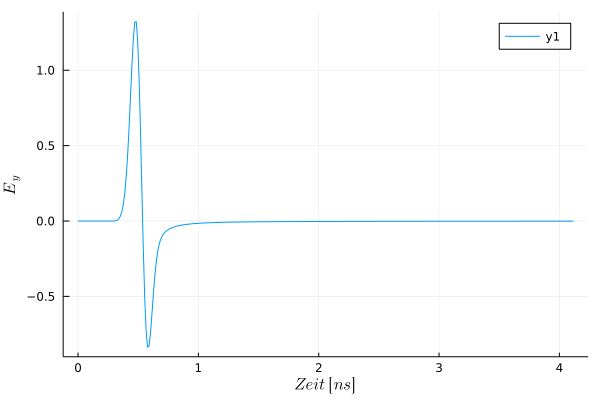

In [238]:
# Plot of time history of selcted location.
time=(range(0,M-1, step=1) |> collect)*delta_t
Plots.plot(time/1e-9,transpose(E_y_point1))
Plots.xlabel!(L"Zeit \ [ns]")
Plots.ylabel!(L"E_y")

┌ Info: Saved animation to 
│   fn = C:\Users\Joshua\Documents\Uni\Master\CEM\FDTD_PML\FDTD_PML\tmp.gif
└ @ Plots C:\Users\Joshua\.julia\packages\Plots\OchXa\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Joshua\\Documents\\Uni\\Master\\CEM\\FDTD_PML\\FDTD_PML\\tmp.gif")
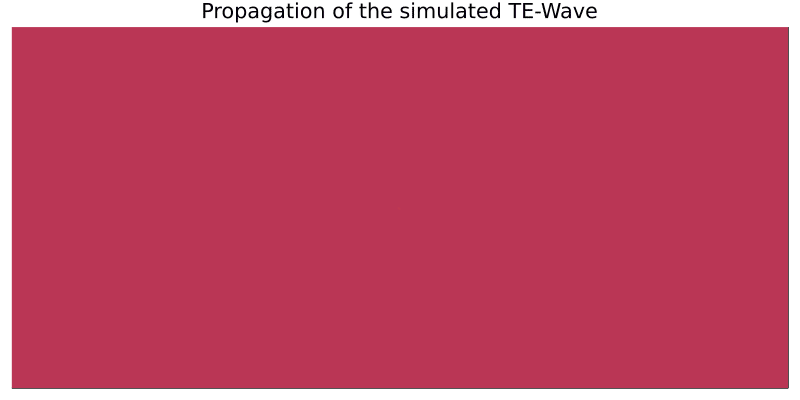

In [239]:
# Visualisation of H_z component
plotsizeX = 400*sizeX      # plot sizeX depends on size of simulation region
plotsizeY = 400*sizeY      # plot sizeX depends on size of simulation region
anim = @animate for i in 1:5:length(movieH)
    Plots.plot(
        [1:N_y],[1:N_x],
        movieH[i],
        st=:surface,
        camera=(0,90),     # topview is simulated, alternative view (30,45) 
        zlim=(-1,1),       # if the values of H_z are increased these values should be modified 
        colorbar=false, 
        size=(plotsizeY, plotsizeX),
        axis=nothing
    )
    Plots.title!("Propagation of the simulated TE-Wave")
end
gif(anim, fps=10)